In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from matplotlib.ticker import ScalarFormatter

In [42]:
df = pd.read_csv('simulation_results_with_pressure_without_early_values.csv', sep = ",", index_col='Unnamed: 0')
display(df)
x = df.drop(columns=["volAverage(T)", "volAverage(Bu)", "rodPressure"])
y = df[["volAverage(T)", "rodPressure"]]

,lhgr,fuel_radius,gap_size,clad_thickness,coolant_temperature,time,volAverage(T),volAverage(Bu),rodPressure
2,25941.6,0.004107,0.000183,0.000954,594.924,6.000000e+01,1430.358,0.032111,5978100.0
3,25941.6,0.004107,0.000183,0.000954,594.924,1.149447e+04,1430.509,6.253517,5978430.0
4,25941.6,0.004107,0.000183,0.000954,594.924,1.942438e+05,1421.217,105.686000,5978440.0
5,25941.6,0.004107,0.000183,0.000954,594.924,3.780361e+05,1391.567,205.686000,5996860.0
6,25941.6,0.004107,0.000183,0.000954,594.924,5.618284e+05,1373.827,305.686000,6005470.0
...,...,...,...,...,...,...,...,...,...
112558,26690.8,0.004876,0.000144,0.000943,585.448,4.936824e+07,1114.919,19606.620000,6337550.0
112559,26690.8,0.004876,0.000144,0.000943,585.448,4.962004e+07,1114.851,19706.620000,6342580.0
112560,26690.8,0.004876,0.000144,0.000943,585.448,4.987183e+07,1114.782,19806.620000,6347610.0
112561,26690.8,0.004876,0.000144,0.000943,585.448,5.012363e+07,1114.712,19906.620000,6352650.0


In [43]:
num_bins = 10
y_T = y['volAverage(T)']
y_P = y['rodPressure']

y_bins_T = pd.qcut(y_T, q=num_bins, duplicates='drop', labels=False)
y_bins_P = pd.qcut(y_P, q=num_bins, duplicates='drop', labels=False)

X_train_T, X_test_T, y_train_T, y_test_T, y_bins_train_T, y_bins_test_T = train_test_split(
    x, y_T, y_bins_T, test_size=0.2, random_state=42, stratify=y_bins_T
)
X_train_P, X_test_P, y_train_P, y_test_P, y_bins_train_P, y_bins_test_P = train_test_split(
    x, y_P, y_bins_P, test_size=0.2, random_state=42, stratify=y_bins_P
)

def random_forests_regressor(outcome, N_trees, N_split):
    if outcome not in ['volAverage(T)', 'rodPressure']:
        print(f'Error, the outcome {outcome} cannot be predicted. Instead volAverage(T) will be predicted.')
        outcome = 'volAverage(T)'
    if outcome == 'rodPressure':
        x = X_train_P
        y = y_train_P
    elif outcome == 'volAverage(T)':
        x = X_train_T
        y = y_train_T

    results = dict()
    y_tests = []
    y_preds = []

    rf_model = RandomForestRegressor(n_estimators=N_trees, random_state=42)
    kf = KFold(n_splits=N_split, shuffle=True, random_state=42)
    rmse_scores, mae_scores, r2s = [], [], []
    best_model = rf_model
    rmse_min = float('inf')

    for train_index, test_index in kf.split(x):
        X_train, X_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_scores.append(rmse)
        mae = mean_absolute_error(y_test, y_pred)
        mae_scores.append(mae)
        y_test = y_test.values
        y_tests.extend(y_test)
        y_preds.extend(y_pred)
        r2 = r2_score(y_test, y_pred)
        r2s.append(r2)
        if rmse<rmse_min:
            rmse_min = rmse
            best_model = rf_model
    results['y_preds'] = y_preds
    results['y_tests'] = y_tests

    mean_rmse, std_rmse = np.mean(rmse_scores), np.std(rmse_scores)
    mean_mae, std_mae = np.mean(mae_scores), np.std(mae_scores)
    mean_r2, std_r2 = np.mean(r2s), np.std(r2s)

    print(f"5-fold cross-validation with {N_trees} trees:")
    print(f"Validation RMSE (mean ± std): {mean_rmse:.3f} ± {std_rmse:.3f}")
    print(f"Validation MAE (mean ± std): {mean_mae:.3f} ± {std_mae:.3f}")
    print(f"Validation $R^2$ (mean ± std): {mean_r2:.6f} ± {std_r2:.6f}")
    return(mean_rmse, std_rmse, mean_mae, std_mae, mean_r2, std_r2, results, best_model)

In [45]:
mean_rmse_T, std_rmse_T, mean_mae_T, std_mae_T, mean_r2_T, std_r2_T, results_T, best_model = random_forests_regressor('volAverage(T)', 50, 5)

rf_test_pred = best_model.predict(X_test_T)

test_results = {
        "RMSE": mean_squared_error(y_test_T, rf_test_pred, squared=False),
        "MAE": mean_absolute_error(y_test_T, rf_test_pred),
        "R2": r2_score(y_test_T, rf_test_pred)
}
print('Test results :')
print(test_results)

5-fold cross-validation with 50 trees:
Validation RMSE (mean ± std): 2.316 ± 0.223
Validation MAE (mean ± std): 0.594 ± 0.013
Validation $R^2$ (mean ± std): 0.999875 ± 0.000025
Test results :
{'RMSE': 2.1876214873273887, 'MAE': 0.5898466552234158, 'R2': 0.9998891807257965}


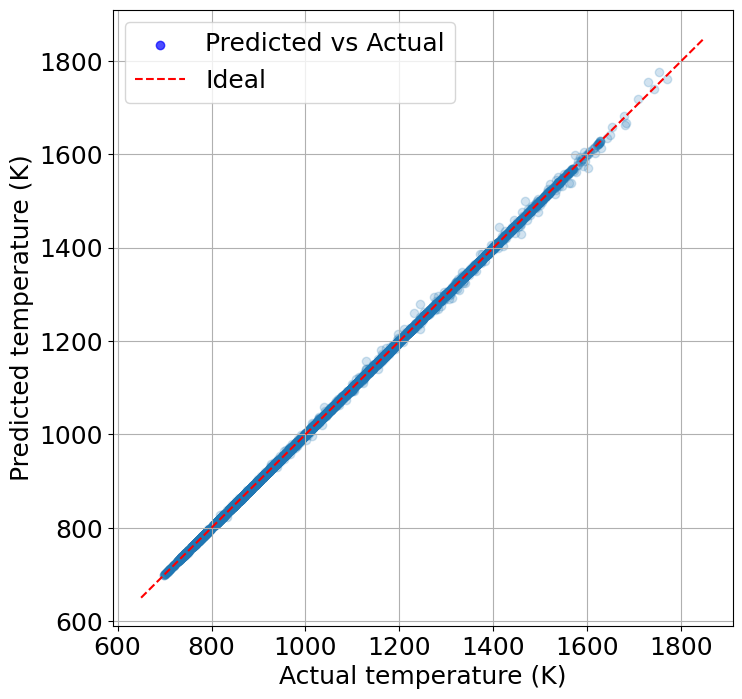

In [23]:
fig = plt.figure(figsize = (8, 8))

num_points = 8000

num_total_points = len(results_T['y_tests'])

random_indices = np.random.choice(num_total_points, size=num_points, replace=False)

plt.scatter(np.array(results_T['y_tests'])[random_indices], np.array(results_T['y_preds'])[random_indices], alpha = 0.2)
plt.scatter([], [], color='blue', alpha = .7, label='Predicted vs Actual')  # Opaque legend point
plt.plot(np.linspace(650, 1850, 1000), np.linspace(650, 1850, 1000), c = 'r', linestyle = '--', label = 'Ideal')
plt.xlabel('Actual temperature (K)', fontsize = 18)
plt.ylabel('Predicted temperature (K)', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18) 
plt.grid()
plt.legend(fontsize = 18)

plt.savefig('Figure Temperature.pdf', format = 'pdf')

In [ ]:
mean_rmse_P, std_rmse_P, mean_mae_P, std_mae_P, mean_r2_P, std_r2_P, results_P, best_model = random_forests_regressor('rodPressure', 50, 5)

rf_test_pred = best_model.predict(X_test_P)

test_results = {
        "RMSE": mean_squared_error(y_test_P, rf_test_pred, squared=False),
        "MAE": mean_absolute_error(y_test_P, rf_test_pred),
        "R2": r2_score(y_test_P, rf_test_pred)
}

print('Test results :')
print(test_results)

5-fold cross-validation with 50 trees:
Validation RMSE (mean ± std): 4773.483 ± 168.663
Validation MAE (mean ± std): 3271.355 ± 69.211
Validation $R^2$ (mean ± std): 0.999968 ± 0.000002
Test results :
{'RMSE': 4709.35174604684, 'MAE': 3272.609259176263, 'R2': 0.9999682220403956}


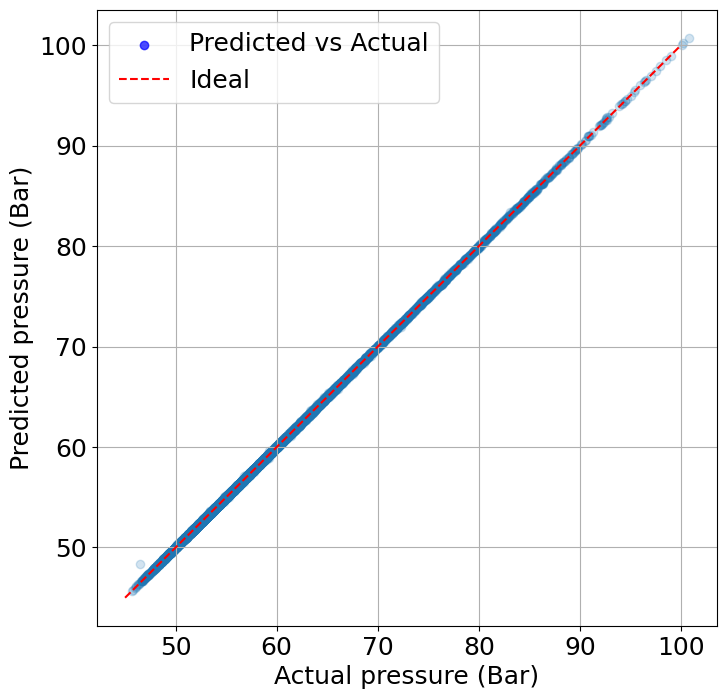

In [25]:
fig = plt.figure(figsize = (8, 8))

num_points = 8000

num_total_points = len(results_P['y_tests'])

random_indices = np.random.choice(num_total_points, size=num_points, replace=False)

plt.scatter(np.array(results_P['y_tests'])[random_indices]/1e5, np.array(results_P['y_preds'])[random_indices]/1e5, alpha = 0.2)
plt.scatter([], [], color='blue', alpha = .7, label='Predicted vs Actual')  # Opaque legend point
plt.plot(np.linspace(4.5e1, 1e2, 1000), np.linspace(4.5e1, 1e2, 1000), c = 'r', linestyle = '--', label = 'Ideal')
plt.xlabel('Actual pressure (Bar)', fontsize = 18)
plt.ylabel('Predicted pressure (Bar)', fontsize = 18)
plt.tick_params(axis='both', which='major', labelsize=18) 
plt.grid()
plt.legend(fontsize = 18)

plt.savefig('Figure pressure.pdf', format = 'pdf')

In [17]:
N_trees = [10, 20, 50, 100, 150, 200]
rmses, maes = [], []
rmse_stds, mae_stds = [], []
r2s, r2_stds = [], []

for N_tree in N_trees:
    mean_rmse_T, std_rmse_T, mean_mae_T, std_mae_T, mean_r2_T, std_r2_T, results_T, best_model = random_forests_regressor('volAverage(T)', N_tree, 5)
    rmses.append(mean_rmse_T)
    maes.append(mean_mae_T)
    rmse_stds.append(std_rmse_T)
    mae_stds.append(std_rmse_T)
    r2s.append(mean_r2_T)
    r2_stds.append(std_r2_T)

5-fold cross-validation with 10 trees:
Validation RMSE (mean ± std): 2.598 ± 0.143
Validation MAE (mean ± std): 0.673 ± 0.015
Validation $R^2$ (mean ± std): 0.999843 ± 0.000018
5-fold cross-validation with 20 trees:
Validation RMSE (mean ± std): 2.403 ± 0.148
Validation MAE (mean ± std): 0.626 ± 0.008
Validation $R^2$ (mean ± std): 0.999866 ± 0.000017
5-fold cross-validation with 50 trees:
Validation RMSE (mean ± std): 2.316 ± 0.223
Validation MAE (mean ± std): 0.594 ± 0.013
Validation $R^2$ (mean ± std): 0.999875 ± 0.000025
5-fold cross-validation with 100 trees:
Validation RMSE (mean ± std): 2.260 ± 0.212
Validation MAE (mean ± std): 0.584 ± 0.017
Validation $R^2$ (mean ± std): 0.999881 ± 0.000023
5-fold cross-validation with 150 trees:
Validation RMSE (mean ± std): 2.269 ± 0.199
Validation MAE (mean ± std): 0.581 ± 0.016
Validation $R^2$ (mean ± std): 0.999880 ± 0.000021
5-fold cross-validation with 200 trees:
Validation RMSE (mean ± std): 2.267 ± 0.205
Validation MAE (mean ± std): 

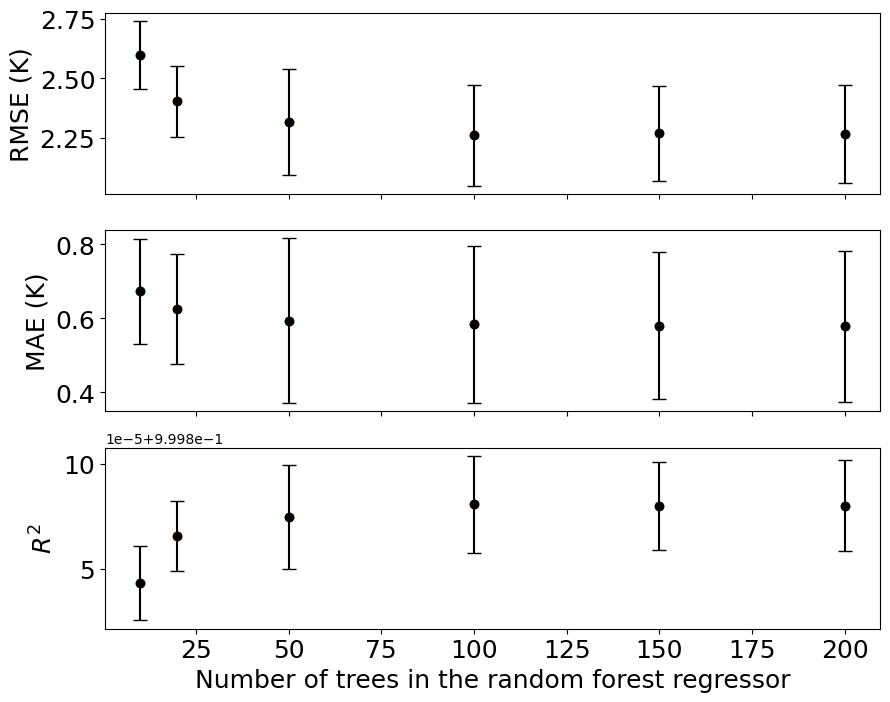

In [18]:
N_trees = [10, 20, 50, 100, 150, 200]

fig, axs = plt.subplots(3,1,figsize = (10,8), sharex = True)
for i, N_tree in enumerate(N_trees):
    axs[0].scatter(N_tree, rmses[i])
    axs[1].scatter(N_tree, maes[i])
    axs[2].scatter(N_tree, r2s[i])
    axs[0].errorbar(N_tree, rmses[i], yerr=rmse_stds[i], fmt='o', color='black', capsize=5, label='Standard deviation' if i == 0 else "")
    axs[1].errorbar(N_tree, maes[i], yerr=mae_stds[i], fmt='o', color='black', capsize=5, label='Standard deviation' if i == 0 else "")
    axs[2].errorbar(N_tree, r2s[i], yerr=r2_stds[i], fmt='o', color='black', capsize=5, label='Standard deviation' if i == 0 else "")
    axs[0].set_ylabel('RMSE (K)', fontsize = 18)
    axs[1].set_ylabel('MAE (K)', fontsize = 18)
    axs[2].set_ylabel('$R^2$', fontsize = 18)
    axs[2].set_xlabel('Number of trees in the random forest regressor', fontsize = 18)
    axs[0].tick_params(axis='both', which='major', labelsize=18) 
    axs[1].tick_params(axis='both', which='major', labelsize=18) 
    axs[2].tick_params(axis='both', which='major', labelsize=18) 

plt.savefig('Temperature errors vs Ntrees.pdf', format = 'pdf', bbox_inches = 'tight')

In [20]:
N_trees = [10, 20, 50, 100, 150, 200]
rmses_P, maes_P = [], []
rmse_stds_P, mae_stds_P = [], []
r2s_P, r2_stds_P = [], []

for N_tree in N_trees:
    mean_rmse_P, std_rmse_P, mean_mae_P, std_mae_P, mean_r2_P, std_r2_P, results_P, best_model = random_forests_regressor('rodPressure', N_tree, 5)
    rmses_P.append(mean_rmse_P)
    maes_P.append(mean_mae_P)
    rmse_stds_P.append(std_rmse_P)
    mae_stds_P.append(std_rmse_P)
    r2s_P.append(mean_r2_P)
    r2_stds_P.append(std_r2_P)

5-fold cross-validation with 10 trees:
Validation RMSE (mean ± std): 5636.605 ± 113.135
Validation MAE (mean ± std): 3833.724 ± 46.884
Validation $R^2$ (mean ± std): 0.999955 ± 0.000002
5-fold cross-validation with 20 trees:
Validation RMSE (mean ± std): 5103.769 ± 104.938
Validation MAE (mean ± std): 3498.934 ± 56.036
Validation $R^2$ (mean ± std): 0.999963 ± 0.000002
5-fold cross-validation with 50 trees:
Validation RMSE (mean ± std): 4773.483 ± 168.663
Validation MAE (mean ± std): 3271.355 ± 69.211
Validation $R^2$ (mean ± std): 0.999968 ± 0.000002
5-fold cross-validation with 100 trees:
Validation RMSE (mean ± std): 4650.049 ± 162.151
Validation MAE (mean ± std): 3182.326 ± 66.002
Validation $R^2$ (mean ± std): 0.999969 ± 0.000002
5-fold cross-validation with 150 trees:
Validation RMSE (mean ± std): 4622.868 ± 183.947
Validation MAE (mean ± std): 3157.856 ± 65.792
Validation $R^2$ (mean ± std): 0.999970 ± 0.000003
5-fold cross-validation with 200 trees:
Validation RMSE (mean ± std)

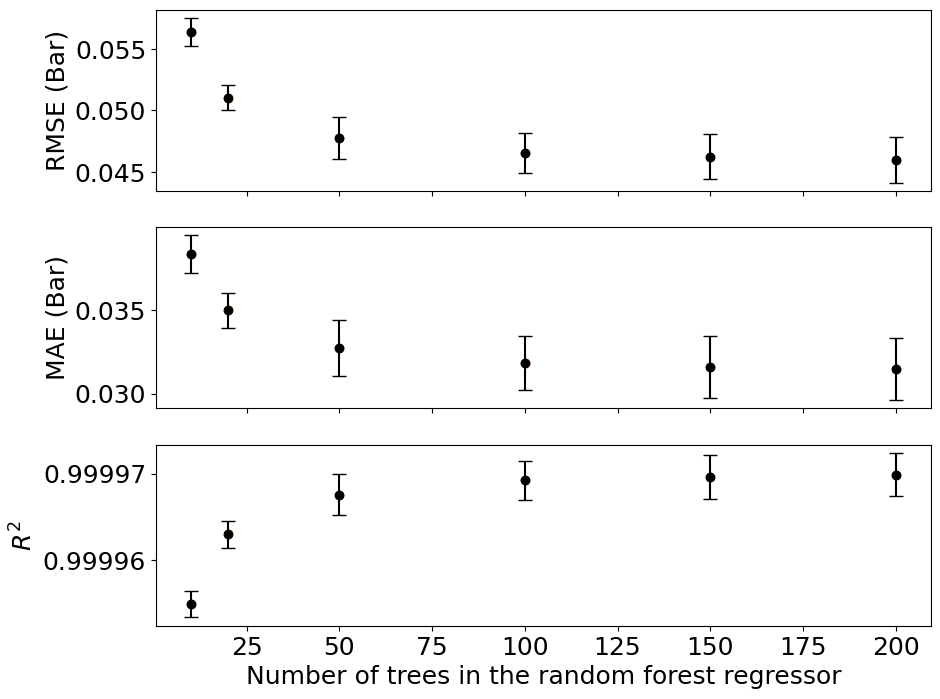

In [21]:
N_trees = [10, 20, 50, 100, 150, 200]

fig, axs = plt.subplots(3,1,figsize = (10,8), sharex = True)
for i, N_tree in enumerate(N_trees):
    axs[0].scatter(N_tree, rmses_P[i]/1e5)
    axs[1].scatter(N_tree, maes_P[i]/1e5)
    axs[2].scatter(N_tree, r2s_P[i])
    axs[0].errorbar(N_tree, rmses_P[i]/1e5, yerr=rmse_stds_P[i]/1e5, fmt='o', color='black', capsize=5, label='Standard deviation' if i == 0 else "")
    axs[1].errorbar(N_tree, maes_P[i]/1e5, yerr=mae_stds_P[i]/1e5, fmt='o', color='black', capsize=5, label='Standard deviation' if i == 0 else "")
    axs[2].errorbar(N_tree, r2s_P[i], yerr=r2_stds_P[i], fmt='o', color='black', capsize=5, label='Standard deviation' if i == 0 else "")
    axs[0].set_ylabel('RMSE (Bar)', fontsize = 18)
    axs[1].set_ylabel('MAE (Bar)', fontsize = 18)
    axs[2].set_ylabel('$R^2$', fontsize = 18)
    axs[2].set_xlabel('Number of trees in the random forest regressor', fontsize = 18)
    axs[0].tick_params(axis='both', which='major', labelsize=18) 
    axs[1].tick_params(axis='both', which='major', labelsize=18) 
    axs[2].tick_params(axis='both', which='major', labelsize=18) 
    axs[2].yaxis.set_major_formatter(ScalarFormatter(useOffset=False))

plt.savefig('Pressure errors vs Ntrees.pdf', format = 'pdf', bbox_inches = 'tight')